In [2]:
#Import inital libraries
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset
def load_data(file_path):

    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully! Shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

file_path = '/content/drive/My Drive/Shopping_Cart_Abandonment_Analysis/events.csv'

df = load_data(file_path)


Data loaded successfully! Shape: (885129, 9)


In [5]:
#Inspect dataset
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
#Check for null values
df.isnull().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,236047
brand,212232
price,0
user_id,0
user_session,162


In [9]:
#Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])


In [10]:
#Fill missing categorical values with "unkown"
df['category_code'].fillna("unkown", inplace=True)
df['brand'].fillna("unkown", inplace=True)
df.isnull().sum()

<ipython-input-10-b1dfd3a59baa>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category_code'].fillna("unkown", inplace=True)
<ipython-input-10-b1dfd3a59baa>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,0
brand,0
price,0
user_id,0
user_session,162


In [11]:
#Drop any rows with missing values in critical columns
df.dropna(subset=['user_id', 'product_id'], inplace=True)
df[['user_id', 'product_id']].isnull().sum()

,0
user_id,0
product_id,0


In [12]:
#Rename data set
FinalDF = df

In [13]:
#Verify dataset
FinalDF.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,unkown,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,unkown,unkown,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,unkown,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [14]:
FinalDF['event_type']

,event_type
0,view
1,view
2,view
3,view
4,view
...,...
885124,view
885125,view
885126,view
885127,view


In [15]:
#Feature Engineering
def feature_engineering(FinalDF):
    #Group b user_session to create session-based metrics
    session_features = FinalDF.groupby('user_session').agg(
        session_duration=('event_time', lambda x: (x.max() - x.min()).seconds),
        num_events=('event_type', 'count'),
        num_products_viewed=('product_id', 'nunique'),
        num_cart=('event_type', lambda x: (x== 'cart').sum()),
        num_purchases=('event_type', lambda x: (x== 'purchase').sum())
    ).reset_index()

    #Add the target variable: 1 for abandonment, 0 for purchase
    session_features['abandoned'] = session_features['num_cart'] > 0
    session_features['abandoned'] &= session_features['num_purchases'] == 0

    print("\n--- Feature Engineering Completed ---")
    print(session_features.head())
    return session_features

#Generate session-based features.
session_features = feature_engineering(FinalDF)


--- Feature Engineering Completed ---
                           user_session  session_duration  num_events  \
0                            000AMhYaQu                 0           1   
1  000c34fa-991f-442a-8e07-8c472269bec6                 0           1   
2                            001HttdHUk                 0           1   
3                            001P7lK0Pt                13           2   
4                            001RxUtFJa                 0           1   

   num_products_viewed  num_cart  num_purchases  abandoned  
0                    1         0              0      False  
1                    1         0              0      False  
2                    1         0              0      False  
3                    2         0              0      False  
4                    1         0              0      False  


In [16]:
#Begin ML Proccess
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [17]:
#Impliment grid search for Random Forest

#Features and targaet
X = session_features[['session_duration', 'num_events', 'num_products_viewed', 'num_cart']]
y = session_features['abandoned']

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Tune the Random Forest model using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train_resampled, y_train_resampled)

#Possible Best model
best_model = grid_search.best_estimator_

#Train the model on the resampled data
best_model.fit(X_train_resampled, y_train_resampled)

#Predict on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.6
y_pred_threshold = (y_pred_proba >= threshold).astype(int)

# Model evaluation
print("\n--- Model Evaluation with Adjusted Threshold ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_threshold))
print("\nClassification Report:\n", classification_report(y_test, y_pred_threshold))

#Print the best paramaters
print("\nBest Parameters:", grid_search.best_params_)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



--- Model Evaluation with Adjusted Threshold ---
Confusion Matrix:
 [[90920  3056]
 [  326  3778]]

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.97      0.98     93976
        True       0.55      0.92      0.69      4104

    accuracy                           0.97     98080
   macro avg       0.77      0.94      0.84     98080
weighted avg       0.98      0.97      0.97     98080


Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}


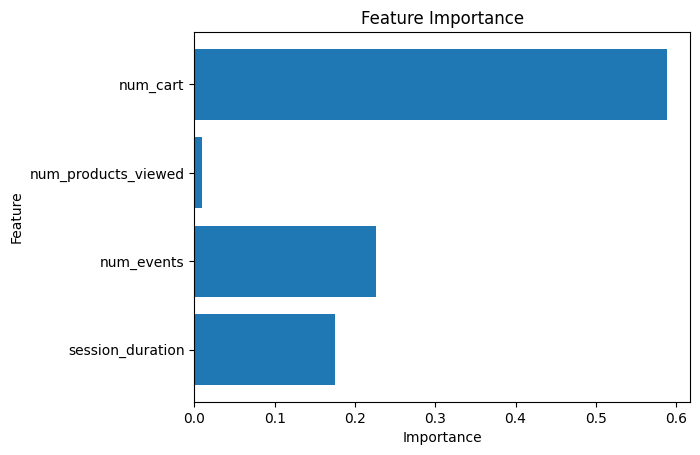

In [18]:
import matplotlib.pyplot as plt
feature_importances = best_model.feature_importances_
features = ['session_duration', 'num_events', 'num_products_viewed', 'num_cart']
plt.barh(features, feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


In [19]:
# Save the refined dataset
refined_file_path = '/content/refined_data.csv'
session_features.to_csv(refined_file_path, index=False)
print(f"Refined data saved to {refined_file_path}")


Refined data saved to /content/refined_data.csv


In [20]:
from google.colab import drive
drive.mount('/content/drive')

# Load the original dataset
original_data = pd.read_csv('/content/drive/My Drive/events.csv')

# Ensure price_range column exists in original data
price_bins = [0, 20, 50, 100, 200, 500, 1000, float('inf')]
price_labels = ['0-20', '20-50', '50-100', '100-200', '200-500', '500-1000', '1000+']
original_data['price_range'] = pd.cut(original_data['price'], bins=price_bins, labels=price_labels, right=False)

# Merge the session_features with the original dataset
merged_data = original_data.merge(session_features, on='user_session', how='left')

merged_data.drop_duplicates(inplace=True)

# Save the merged dataset
merged_data.to_csv('/content/drive/My Drive/merged_data_complete.csv', index=False)
print("Merged dataset saved to Google Drive!")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Merged dataset saved to Google Drive!
